In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

## Data preparation

 As the Kaggle entry states, the folder 'dataset2-master' contains 2,500 augmented images with 4 additional subtype labels (JPEG + CSV).

In [3]:
# Make path variable and determine desired image dimensions
# test_path = r'/homes/maschepers/Documents/Cell_data_DeepLearning/dataset2-master/dataset2-master/images/TEST/'
# train_path = r'/homes/maschepers/Documents/Cell_data_DeepLearning/dataset2-master/dataset2-master/images/TRAIN/'

test_path = r'C:\\Users\\Martin Schepers\\Documents\\dataset2-master\\dataset2-master\\images\\TEST\\'
train_path = r'C:\\Users\\Martin Schepers\\Documents\\dataset2-master\\dataset2-master\\images\\TRAIN\\'

train_data = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_generator = train_data.flow_from_directory(
    directory=train_path,
    batch_size=20,
    color_mode='rgb',
    target_size=(120, 160),
    class_mode='categorical'
)

test_data = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = test_data.flow_from_directory(
    directory=test_path,
    batch_size=20,
    color_mode='rgb',
    target_size=(120, 160),
    class_mode='categorical'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [4]:

def get_data(generator, batch_size):
    # Store the data in X, y variables by iterating over the batches
    generator.reset()
    X, y = next(generator)
    for i in range(int(len(generator)/batch_size)-1): #1st batch is already fetched before the for loop.
        img, label = next(generator)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    print(X.shape, y.shape)
    return X, y

# A subset of the data will be used as to not overload these models
X_train, y_train = get_data(train_generator, 2)
X_test, y_test = get_data(test_generator, 2)

y_train

(4980, 120, 160, 3) (4980, 4)
(1240, 120, 160, 3) (1240, 4)


array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

## Deep learning model creation

In [5]:
# create model
neural = keras.models.Sequential()

neural.add(keras.layers.InputLayer(input_shape=(120, 160, 3), name='Input'))
neural.add(keras.layers.Flatten())
neural.add(keras.layers.Dense(units=32, activation='LeakyReLU', name='Hidden_1'))
neural.add(keras.layers.Dense(units=64, activation='LeakyReLU', name='Hidden_2'))
# neural.add(keras.layers.Dropout(0.3))
neural.add(keras.layers.Dense(units=128, activation='LeakyReLU', name='Hidden_3'))
neural.add(keras.layers.Dropout(0.3))
neural.add(keras.layers.Dense(units=4, activation='softmax', name='Output'))

neural.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 Hidden_1 (Dense)            (None, 32)                1843232   
                                                                 
 Hidden_2 (Dense)            (None, 64)                2112      
                                                                 
 Hidden_3 (Dense)            (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 Output (Dense)              (None, 4)                 516       
                                                                 
Total params: 1,854,180
Trainable params: 1,854,180
Non-

In [6]:
neural.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.RMSprop(),  # learning_rate=1e-6
    metrics=keras.metrics.CategoricalAccuracy()
)

In [7]:
history = neural.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    batch_size=250,
    verbose=1,
    validation_data=(X_test, y_test)  # np.random.shuffle(y_test)
)

history.history.keys()

Epoch 1/30
20/20 [==============================] - 4s 84ms/step - loss: 25.5862 - categorical_accuracy: 0.2602 - val_loss: 2.1709 - val_categorical_accuracy: 0.2500
Epoch 2/30
20/20 [==============================] - 1s 56ms/step - loss: 7.0870 - categorical_accuracy: 0.2598 - val_loss: 5.0267 - val_categorical_accuracy: 0.2573
Epoch 3/30
20/20 [==============================] - 1s 57ms/step - loss: 5.0781 - categorical_accuracy: 0.2514 - val_loss: 2.3933 - val_categorical_accuracy: 0.2573
Epoch 4/30
20/20 [==============================] - 1s 56ms/step - loss: 5.5628 - categorical_accuracy: 0.2510 - val_loss: 4.3656 - val_categorical_accuracy: 0.2516
Epoch 5/30
20/20 [==============================] - 1s 59ms/step - loss: 4.5188 - categorical_accuracy: 0.2560 - val_loss: 13.3135 - val_categorical_accuracy: 0.2403
Epoch 6/30
20/20 [==============================] - 1s 58ms/step - loss: 4.1144 - categorical_accuracy: 0.2446 - val_loss: 2.0244 - val_categorical_accuracy: 0.2500
Epoch 7/

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

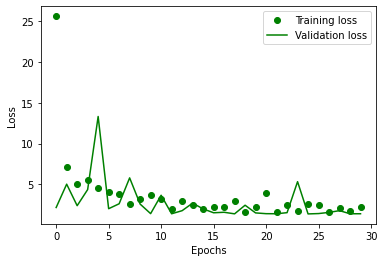

In [8]:
plt.plot(history.history['loss'], 'go', label='Training loss')
plt.plot(history.history['val_loss'], 'g-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

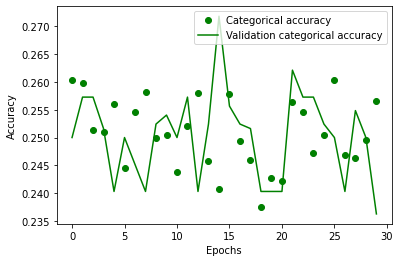

In [9]:
plt.plot(history.history['categorical_accuracy'], 'go', label='Categorical accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'g-', label='Validation categorical accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()